In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.4 MB/s eta 0:00:00


In [2]:
import optuna

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()

# Display column names
df.columns
df
# Create lag features (past 3 lags for each variable)

df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
data=df.copy()

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 8.43MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


In [6]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


# ALL

## 1

In [7]:

df=data.copy()
df = df.astype(float)


In [8]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [9]:
# Number of lags to create
lags = 1
lagged_features = create_lagged_features(df, lags)


In [10]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [11]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1
Date                                  
2000-01-31   0.329139              NaN
2000-02-28   1.940367         0.329139
2000-03-31   4.469678         1.940367
2000-04-30   3.672022         4.469678
2000-05-31   2.382412         3.672022
...               ...              ...
2024-11-30  -2.068252        -0.783699
2024-12-31  -1.742696        -2.068252
2025-01-31  -4.035874        -1.742696
2025-02-28  -4.187438        -4.035874
2025-03-31  -2.592781        -4.187438

[303 rows x 2 columns]


In [12]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1'], dtype='object')


In [13]:
df2=lagged_features.dropna()

In [14]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1
Date                                  
2000-02-28   1.940367         0.329139
2000-03-31   4.469678         1.940367
2000-04-30   3.672022         4.469678
2000-05-31   2.382412         3.672022
2000-06-30   6.799835         2.382412
...               ...              ...
2024-11-30  -2.068252        -0.783699
2024-12-31  -1.742696        -2.068252
2025-01-31  -4.035874        -1.742696
2025-02-28  -4.187438        -4.035874
2025-03-31  -2.592781        -4.187438

[302 rows x 2 columns]


302

In [15]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0


In [16]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [17]:
df2

,Inflation,Inflation_lag_1
Date,,
2000-02-28,1.940367,0.329139
2000-03-31,4.469678,1.940367
2000-04-30,3.672022,4.469678
2000-05-31,2.382412,3.672022
2000-06-30,6.799835,2.382412
...,...,...
2024-11-30,-2.068252,-0.783699
2024-12-31,-1.742696,-2.068252
2025-01-31,-4.035874,-1.742696


In [18]:
train_size = int(len(df2) * 0.7)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [19]:
train_data

,Inflation,Inflation_lag_1
Date,,
2000-02-28,1.940367,0.329139
2000-03-31,4.469678,1.940367
2000-04-30,3.672022,4.469678
2000-05-31,2.382412,3.672022
2000-06-30,6.799835,2.382412
...,...,...
2017-04-30,6.940639,7.274401
2017-05-31,6.008969,6.940639
2017-06-30,6.095406,6.008969


In [20]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [21]:
train_data

,Inflation,Inflation_lag_1
Date,,
2000-02-28,1.940367,0.329139
2000-03-31,4.469678,1.940367
2000-04-30,3.672022,4.469678
2000-05-31,2.382412,3.672022
2000-06-30,6.799835,2.382412
...,...,...
2017-04-30,6.940639,7.274401
2017-05-31,6.008969,6.940639
2017-06-30,6.095406,6.008969


In [22]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2017-09-30,7.066190
2017-10-31,7.760928
2017-11-30,7.570423
2017-12-31,7.149085
2018-01-31,5.770887
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
xtrain.columns

Index(['Inflation_lag_1'], dtype='object')

In [25]:
ytrain

,Inflation
Date,
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
2000-06-30,6.799835
...,...
2017-04-30,6.940639
2017-05-31,6.008969
2017-06-30,6.095406


In [26]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [27]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [28]:
xtrain

,Inflation_lag_1
Date,
2000-02-28,0.329139
2000-03-31,1.940367
2000-04-30,4.469678
2000-05-31,3.672022
2000-06-30,2.382412
...,...
2017-04-30,7.274401
2017-05-31,6.940639
2017-06-30,6.008969


In [29]:
df1=pd.DataFrame(ytrain)

In [30]:
X_train_scaled

array([[0.        ],
       [0.05779654],
       [0.14852572],
       [0.11991291],
       [0.07365317],
       [0.23211106],
       [0.35192041],
       [0.34245908],
       [0.29151419],
       [0.26779056],
       [0.25936345],
       [0.37691893],
       [0.56824453],
       [0.58430399],
       [0.4621915 ],
       [0.4858699 ],
       [0.57134596],
       [0.51455021],
       [0.46775373],
       [0.39790749],
       [0.52434877],
       [0.4949602 ],
       [0.5209835 ],
       [0.37620882],
       [0.30734693],
       [0.29355464],
       [0.39783942],
       [0.28437225],
       [0.34657202],
       [0.37240612],
       [0.37565693],
       [0.35006312],
       [0.2533846 ],
       [0.28071459],
       [0.31298823],
       [0.39314525],
       [0.47697028],
       [0.38158025],
       [0.27227289],
       [0.28637759],
       [0.20395529],
       [0.14912908],
       [0.11036019],
       [0.11933827],
       [0.16067257],
       [0.12817107],
       [0.14784693],
       [0.168

In [31]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [32]:
X_train_scaled_df

,Inflation_lag_1
Date,
2000-02-28,0.000000
2000-03-31,0.057797
2000-04-30,0.148526
2000-05-31,0.119913
2000-06-30,0.073653
...,...
2017-04-30,0.249134
2017-05-31,0.237162
2017-06-30,0.203742


In [33]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [34]:
df3

,Inflation,Inflation_lag_1
Date,,
2000-02-28,1.940367,0.000000
2000-03-31,4.469678,0.057797
2000-04-30,3.672022,0.148526
2000-05-31,2.382412,0.119913
2000-06-30,6.799835,0.073653
...,...,...
2017-04-30,6.940639,0.249134
2017-05-31,6.008969,0.237162
2017-06-30,6.095406,0.203742


In [35]:
X_train_scaled_df

,Inflation_lag_1
Date,
2000-02-28,0.000000
2000-03-31,0.057797
2000-04-30,0.148526
2000-05-31,0.119913
2000-06-30,0.073653
...,...
2017-04-30,0.249134
2017-05-31,0.237162
2017-06-30,0.203742


In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 04:17:57,807] A new study created in memory with name: no-name-82714422-8e7a-4642-ac06-c71c8dd643f6
[I 2025-05-29 04:18:11,508] Trial 0 finished with value: 0.006754518020898104 and parameters: {'input_units': 32, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.4299744676609233, 'n_units_1': 112, 'dropout_rate_1': 0.3042674657839831, 'optimizer': 'RMSprop', 'batch_size': 48, 'epochs': 40}. Best is trial 0 with value: 0.006754518020898104.
[I 2025-05-29 04:18:38,713] Trial 1 finished with value: 0.015296755358576775 and parameters: {'input_units': 16, 'activation': 'relu', 'num_layers': 3, 'n_units_0': 32, 'dropout_rate_0': 0.0013476897863008985, 'n_units_1': 128, 'dropout_rate_1': 0.10218835866773923, 'n_units_2': 32, 'dropout_rate_2': 0.08566832628579041, 'optimizer': 'SGD', 'batch_size': 48, 'epochs': 90}. Best is trial 0 with value: 0.006754518020898104.
[I 2025-05-29 04:19:00,253] Trial 2 finished with value: 0.003224457707256079 and parame

Best hyperparameters:  {'input_units': 32, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.47811998264682126, 'n_units_1': 48, 'dropout_rate_1': 0.32276497162335416, 'optimizer': 'RMSprop', 'batch_size': 16, 'epochs': 30}


Best hyperparameters:  {'input_units': 112, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.4911298147309582, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 90}

Best hyperparameters:  {'input_units': 32, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.47811998264682126, 'n_units_1': 48, 'dropout_rate_1': 0.32276497162335416, 'optimizer': 'RMSprop', 'batch_size': 16, 'epochs': 30}
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0357 - mae: 0.1277 - val_loss: 0.0014 - val_mae: 0.0291
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0146 - mae: 0.0884 - val_loss: 0.0015 - val_mae: 0.0295
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - mae: 0.0766 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103 - mae: 0.0767 - val_loss: 0.0019 - val_mae: 0.0376
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117 - mae: 0.0733 - val_loss: 0.0016 - val_mae: 0.0298
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0101 - mae: 0.0717 - val_loss: 0.0013 - val_mae: 0.0275
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step -

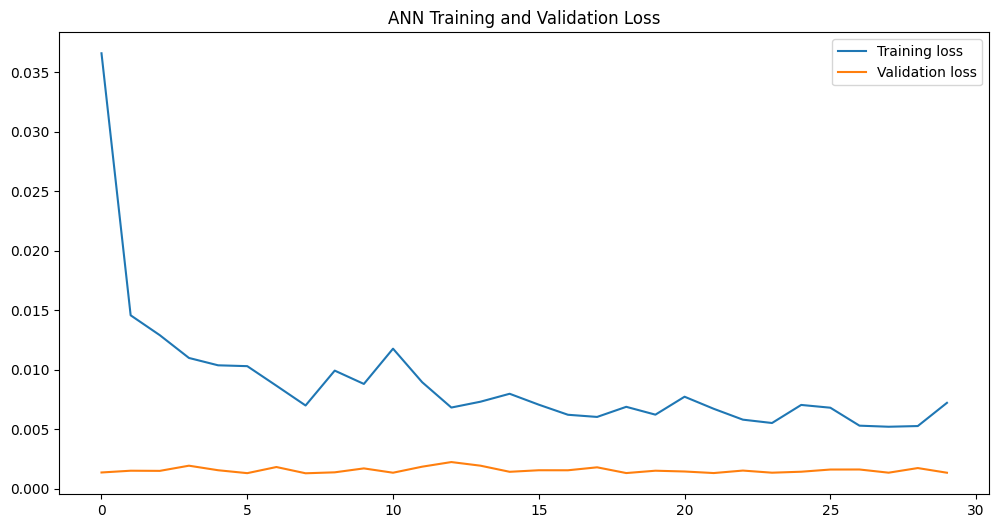

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [38]:
test_predictions_scaled=model.predict(X_test_scaled)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [39]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 25.4064
RMSE: 5.0405
MAE: 2.6550
MAPE: 36.57%
R²: 0.9213


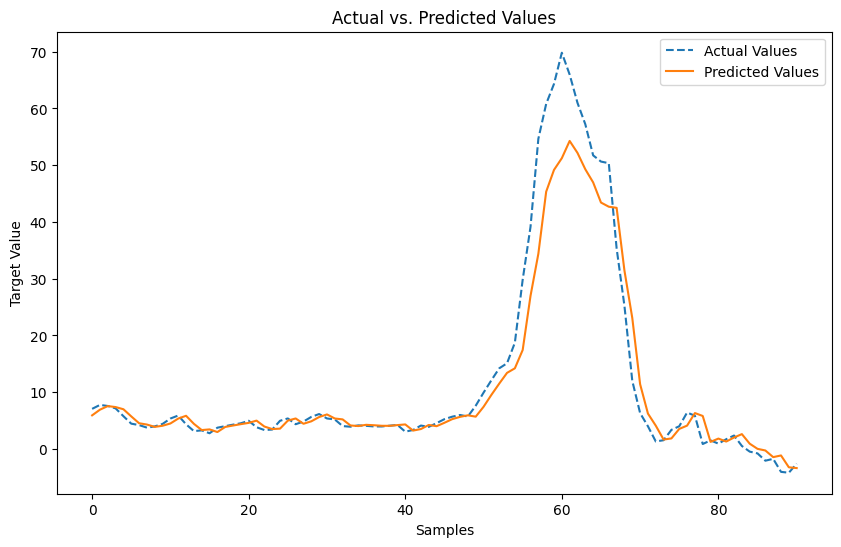

In [40]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 2

In [41]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [42]:

df=data.copy()
df = df.astype(float)


In [43]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [44]:
# Number of lags to create
lags = 2
lagged_features = create_lagged_features(df, lags)


In [45]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [46]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2
Date                                                   
2000-01-31   0.329139              NaN              NaN
2000-02-28   1.940367         0.329139              NaN
2000-03-31   4.469678         1.940367         0.329139
2000-04-30   3.672022         4.469678         1.940367
2000-05-31   2.382412         3.672022         4.469678
...               ...              ...              ...
2024-11-30  -2.068252        -0.783699        -0.469239
2024-12-31  -1.742696        -2.068252        -0.783699
2025-01-31  -4.035874        -1.742696        -2.068252
2025-02-28  -4.187438        -4.035874        -1.742696
2025-03-31  -2.592781        -4.187438        -4.035874

[303 rows x 3 columns]


In [47]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2'], dtype='object')


In [48]:
df2=lagged_features.dropna()

In [49]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2
Date                                                   
2000-03-31   4.469678         1.940367         0.329139
2000-04-30   3.672022         4.469678         1.940367
2000-05-31   2.382412         3.672022         4.469678
2000-06-30   6.799835         2.382412         3.672022
2000-07-31  10.139831         6.799835         2.382412
...               ...              ...              ...
2024-11-30  -2.068252        -0.783699        -0.469239
2024-12-31  -1.742696        -2.068252        -0.783699
2025-01-31  -4.035874        -1.742696        -2.068252
2025-02-28  -4.187438        -4.035874        -1.742696
2025-03-31  -2.592781        -4.187438        -4.035874

[301 rows x 3 columns]


301

In [50]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0


In [51]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [52]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2
Date,,,
2000-03-31,4.469678,1.940367,0.329139
2000-04-30,3.672022,4.469678,1.940367
2000-05-31,2.382412,3.672022,4.469678
2000-06-30,6.799835,2.382412,3.672022
2000-07-31,10.139831,6.799835,2.382412
...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239
2024-12-31,-1.742696,-2.068252,-0.783699
2025-01-31,-4.035874,-1.742696,-2.068252


In [53]:
train_size = int(len(df2) * 0.7)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [54]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2
Date,,,
2000-03-31,4.469678,1.940367,0.329139
2000-04-30,3.672022,4.469678,1.940367
2000-05-31,2.382412,3.672022,4.469678
2000-06-30,6.799835,2.382412,3.672022
2000-07-31,10.139831,6.799835,2.382412
...,...,...,...
2017-04-30,6.940639,7.274401,6.770357
2017-05-31,6.008969,6.940639,7.274401
2017-06-30,6.095406,6.008969,6.940639


In [55]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [56]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2
Date,,,
2000-03-31,4.469678,1.940367,0.329139
2000-04-30,3.672022,4.469678,1.940367
2000-05-31,2.382412,3.672022,4.469678
2000-06-30,6.799835,2.382412,3.672022
2000-07-31,10.139831,6.799835,2.382412
...,...,...,...
2017-04-30,6.940639,7.274401,6.770357
2017-05-31,6.008969,6.940639,7.274401
2017-06-30,6.095406,6.008969,6.940639


In [57]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2017-09-30,7.066190
2017-10-31,7.760928
2017-11-30,7.570423
2017-12-31,7.149085
2018-01-31,5.770887
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [58]:
from sklearn.preprocessing import MinMaxScaler

In [59]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2'], dtype='object')

In [60]:
ytrain

,Inflation
Date,
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
2000-06-30,6.799835
2000-07-31,10.139831
...,...
2017-04-30,6.940639
2017-05-31,6.008969
2017-06-30,6.095406


In [61]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [62]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [63]:
xtrain

,Inflation_lag_1,Inflation_lag_2
Date,,
2000-03-31,1.940367,0.329139
2000-04-30,4.469678,1.940367
2000-05-31,3.672022,4.469678
2000-06-30,2.382412,3.672022
2000-07-31,6.799835,2.382412
...,...,...
2017-04-30,7.274401,6.770357
2017-05-31,6.940639,7.274401
2017-06-30,6.008969,6.940639


In [64]:
df1=pd.DataFrame(ytrain)

In [65]:
X_train_scaled

array([[0.04334777, 0.        ],
       [0.13546829, 0.05779654],
       [0.1064167 , 0.14852572],
       [0.05944757, 0.11991291],
       [0.22033542, 0.07365317],
       [0.34198205, 0.23211106],
       [0.33237564, 0.35192041],
       [0.2806495 , 0.34245908],
       [0.25656207, 0.29151419],
       [0.24800572, 0.26779056],
       [0.36736392, 0.25936345],
       [0.56162353, 0.37691893],
       [0.57792925, 0.56824453],
       [0.45394416, 0.58430399],
       [0.47798567, 0.4621915 ],
       [0.56477251, 0.4858699 ],
       [0.5071058 , 0.57134596],
       [0.45959169, 0.51455021],
       [0.38867435, 0.46775373],
       [0.51705461, 0.39790749],
       [0.48721537, 0.52434877],
       [0.51363774, 0.4949602 ],
       [0.36664293, 0.5209835 ],
       [0.29672504, 0.37620882],
       [0.28272124, 0.30734693],
       [0.38860524, 0.29355464],
       [0.27339804, 0.39783942],
       [0.33655164, 0.28437225],
       [0.36278192, 0.34657202],
       [0.36608258, 0.37240612],
       [0.

In [66]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [67]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2
Date,,
2000-03-31,0.043348,0.000000
2000-04-30,0.135468,0.057797
2000-05-31,0.106417,0.148526
2000-06-30,0.059448,0.119913
2000-07-31,0.220335,0.073653
...,...,...
2017-04-30,0.237620,0.231054
2017-05-31,0.225464,0.249134
2017-06-30,0.191531,0.237162


In [68]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [69]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2
Date,,,
2000-03-31,4.469678,0.043348,0.000000
2000-04-30,3.672022,0.135468,0.057797
2000-05-31,2.382412,0.106417,0.148526
2000-06-30,6.799835,0.059448,0.119913
2000-07-31,10.139831,0.220335,0.073653
...,...,...,...
2017-04-30,6.940639,0.237620,0.231054
2017-05-31,6.008969,0.225464,0.249134
2017-06-30,6.095406,0.191531,0.237162


In [70]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2
Date,,
2000-03-31,0.043348,0.000000
2000-04-30,0.135468,0.057797
2000-05-31,0.106417,0.148526
2000-06-30,0.059448,0.119913
2000-07-31,0.220335,0.073653
...,...,...
2017-04-30,0.237620,0.231054
2017-05-31,0.225464,0.249134
2017-06-30,0.191531,0.237162


In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 04:36:23,039] A new study created in memory with name: no-name-37ad8a54-36c1-4bd8-8b10-9c992d836ffd
[I 2025-05-29 04:36:50,967] Trial 0 finished with value: 0.009532817173749208 and parameters: {'input_units': 128, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 128, 'dropout_rate_0': 0.48343200652414936, 'n_units_1': 16, 'dropout_rate_1': 0.17280611160293585, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 80}. Best is trial 0 with value: 0.009532817173749208.
[I 2025-05-29 04:37:05,485] Trial 1 finished with value: 0.004143193108029663 and parameters: {'input_units': 80, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 16, 'dropout_rate_0': 0.2775487215045902, 'n_units_1': 48, 'dropout_rate_1': 0.046399502723513175, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 40}. Best is trial 1 with value: 0.004143193108029663.
[I 2025-05-29 04:37:24,484] Trial 2 finished with value: 0.0488231111317873 and parameters: {'input_units': 112, 'activation': 'sigmoid', 'num_

Best hyperparameters:  {'input_units': 32, 'activation': 'tanh', 'num_layers': 3, 'n_units_0': 80, 'dropout_rate_0': 0.43620928015720883, 'n_units_1': 96, 'dropout_rate_1': 0.09100456739614327, 'n_units_2': 16, 'dropout_rate_2': 0.005358502474408056, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 90}


Best hyperparameters:  {'input_units': 48, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.17002752103955923, 'n_units_1': 128, 'dropout_rate_1': 0.34985530992621416, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 100}

Best hyperparameters:  {'input_units': 32, 'activation': 'tanh', 'num_layers': 3, 'n_units_0': 80, 'dropout_rate_0': 0.43620928015720883, 'n_units_1': 96, 'dropout_rate_1': 0.09100456739614327, 'n_units_2': 16, 'dropout_rate_2': 0.005358502474408056, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 90}
Epoch 1/90
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0925 - mae: 0.2216 - val_loss: 0.0254 - val_mae: 0.1523
Epoch 2/90
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0470 - mae: 0.1741 - val_loss: 0.0016 - val_mae: 0.0305
Epoch 3/90
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0376 - mae: 0.1226 - val_loss: 0.0014 - val_mae: 0.0282
Epoch 4/90
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0137 - mae: 0.0899 - val_loss: 0.0026 - val_mae: 0.0377
Epoch 5/90
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0129 - mae: 0.0841 - val_loss: 0.0015 - val_mae: 0.0311
Epoch 6/90
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0092 - mae: 0.0690 - val_loss: 0.0017 - val_mae: 0.0340
Epo

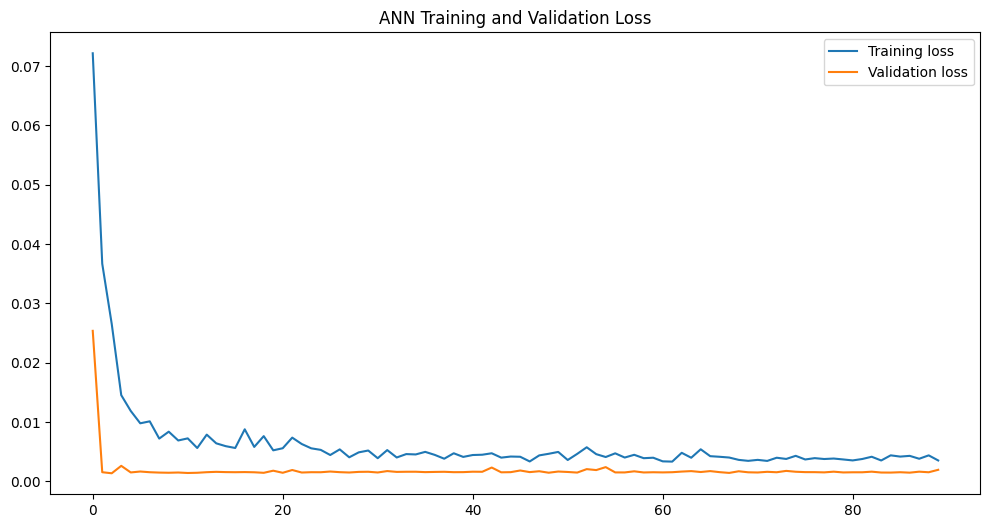

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [73]:
test_predictions_scaled=model.predict(X_test_scaled)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [74]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 23.8831
RMSE: 4.8870
MAE: 2.6168
MAPE: 39.17%
R²: 0.9260


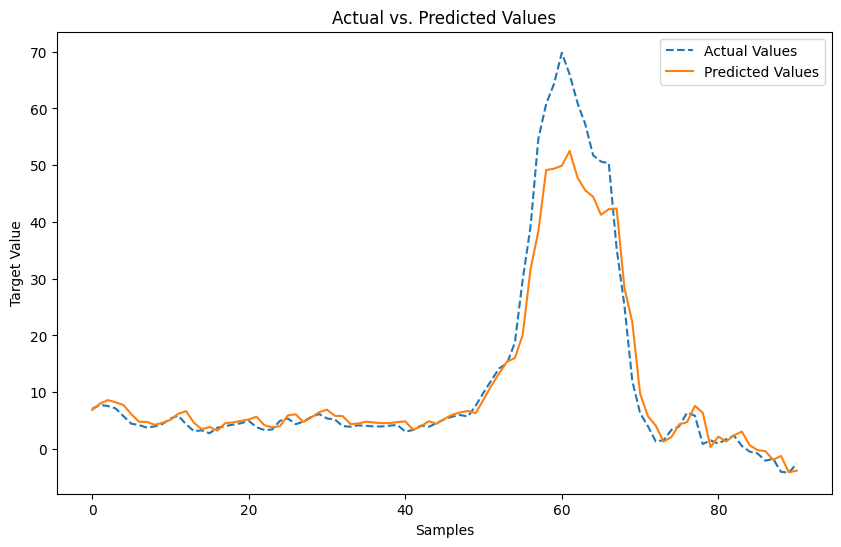

In [75]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 3

In [76]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [77]:

df=data.copy()
df = df.astype(float)


In [78]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [79]:
# Number of lags to create
lags = 3
lagged_features = create_lagged_features(df, lags)


In [80]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [81]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3
Date                                                                    
2000-01-31   0.329139              NaN              NaN              NaN
2000-02-28   1.940367         0.329139              NaN              NaN
2000-03-31   4.469678         1.940367         0.329139              NaN
2000-04-30   3.672022         4.469678         1.940367         0.329139
2000-05-31   2.382412         3.672022         4.469678         1.940367
...               ...              ...              ...              ...
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696

[303 rows x 4 col

In [82]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3'], dtype='object')


In [83]:
df2=lagged_features.dropna()

In [84]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3
Date                                                                    
2000-04-30   3.672022         4.469678         1.940367         0.329139
2000-05-31   2.382412         3.672022         4.469678         1.940367
2000-06-30   6.799835         2.382412         3.672022         4.469678
2000-07-31  10.139831         6.799835         2.382412         3.672022
2000-08-31   9.876072        10.139831         6.799835         2.382412
...               ...              ...              ...              ...
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696

[300 rows x 4 columns]


300

In [85]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0


In [86]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [87]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3
Date,,,,
2000-04-30,3.672022,4.469678,1.940367,0.329139
2000-05-31,2.382412,3.672022,4.469678,1.940367
2000-06-30,6.799835,2.382412,3.672022,4.469678
2000-07-31,10.139831,6.799835,2.382412,3.672022
2000-08-31,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699


In [88]:
train_size = int(len(df2) * 0.7)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [89]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3
Date,,,,
2000-04-30,3.672022,4.469678,1.940367,0.329139
2000-05-31,2.382412,3.672022,4.469678,1.940367
2000-06-30,6.799835,2.382412,3.672022,4.469678
2000-07-31,10.139831,6.799835,2.382412,3.672022
2000-08-31,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...
2017-05-31,6.008969,6.940639,7.274401,6.770357
2017-06-30,6.095406,6.008969,6.940639,7.274401
2017-07-31,4.828797,6.095406,6.008969,6.940639


In [90]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [91]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3
Date,,,,
2000-04-30,3.672022,4.469678,1.940367,0.329139
2000-05-31,2.382412,3.672022,4.469678,1.940367
2000-06-30,6.799835,2.382412,3.672022,4.469678
2000-07-31,10.139831,6.799835,2.382412,3.672022
2000-08-31,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...
2017-05-31,6.008969,6.940639,7.274401,6.770357
2017-06-30,6.095406,6.008969,6.940639,7.274401
2017-07-31,4.828797,6.095406,6.008969,6.940639


In [92]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2017-10-31,7.760928
2017-11-30,7.570423
2017-12-31,7.149085
2018-01-31,5.770887
2018-02-28,4.455870
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [93]:
from sklearn.preprocessing import MinMaxScaler

In [94]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3'], dtype='object')

In [95]:
ytrain

,Inflation
Date,
2000-04-30,3.672022
2000-05-31,2.382412
2000-06-30,6.799835
2000-07-31,10.139831
2000-08-31,9.876072
...,...
2017-05-31,6.008969
2017-06-30,6.095406
2017-07-31,4.828797


In [96]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [97]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [98]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3
Date,,,
2000-04-30,4.469678,1.940367,0.329139
2000-05-31,3.672022,4.469678,1.940367
2000-06-30,2.382412,3.672022,4.469678
2000-07-31,6.799835,2.382412,3.672022
2000-08-31,10.139831,6.799835,2.382412
...,...,...,...
2017-05-31,6.940639,7.274401,6.770357
2017-06-30,6.008969,6.940639,7.274401
2017-07-31,6.095406,6.008969,6.940639


In [99]:
df1=pd.DataFrame(ytrain)

In [100]:
X_train_scaled

array([[0.13546829, 0.04334777, 0.        ],
       [0.1064167 , 0.13546829, 0.05779654],
       [0.05944757, 0.1064167 , 0.14852572],
       [0.22033542, 0.05944757, 0.11991291],
       [0.34198205, 0.22033542, 0.07365317],
       [0.33237564, 0.34198205, 0.23211106],
       [0.2806495 , 0.33237564, 0.35192041],
       [0.25656207, 0.2806495 , 0.34245908],
       [0.24800572, 0.25656207, 0.29151419],
       [0.36736392, 0.24800572, 0.26779056],
       [0.56162353, 0.36736392, 0.25936345],
       [0.57792925, 0.56162353, 0.37691893],
       [0.45394416, 0.57792925, 0.56824453],
       [0.47798567, 0.45394416, 0.58430399],
       [0.56477251, 0.47798567, 0.4621915 ],
       [0.5071058 , 0.56477251, 0.4858699 ],
       [0.45959169, 0.5071058 , 0.57134596],
       [0.38867435, 0.45959169, 0.51455021],
       [0.51705461, 0.38867435, 0.46775373],
       [0.48721537, 0.51705461, 0.39790749],
       [0.51363774, 0.48721537, 0.52434877],
       [0.36664293, 0.51363774, 0.4949602 ],
       [0.

In [101]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [102]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3
Date,,,
2000-04-30,0.135468,0.043348,0.000000
2000-05-31,0.106417,0.135468,0.057797
2000-06-30,0.059448,0.106417,0.148526
2000-07-31,0.220335,0.059448,0.119913
2000-08-31,0.341982,0.220335,0.073653
...,...,...,...
2017-05-31,0.225464,0.237620,0.231054
2017-06-30,0.191531,0.225464,0.249134
2017-07-31,0.194679,0.191531,0.237162


In [103]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [104]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3
Date,,,,
2000-04-30,3.672022,0.135468,0.043348,0.000000
2000-05-31,2.382412,0.106417,0.135468,0.057797
2000-06-30,6.799835,0.059448,0.106417,0.148526
2000-07-31,10.139831,0.220335,0.059448,0.119913
2000-08-31,9.876072,0.341982,0.220335,0.073653
...,...,...,...,...
2017-05-31,6.008969,0.225464,0.237620,0.231054
2017-06-30,6.095406,0.191531,0.225464,0.249134
2017-07-31,4.828797,0.194679,0.191531,0.237162


In [105]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3
Date,,,
2000-04-30,0.135468,0.043348,0.000000
2000-05-31,0.106417,0.135468,0.057797
2000-06-30,0.059448,0.106417,0.148526
2000-07-31,0.220335,0.059448,0.119913
2000-08-31,0.341982,0.220335,0.073653
...,...,...,...
2017-05-31,0.225464,0.237620,0.231054
2017-06-30,0.191531,0.225464,0.249134
2017-07-31,0.194679,0.191531,0.237162


In [106]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 04:55:15,352] A new study created in memory with name: no-name-d6add612-653d-4c38-906d-05e91d2998eb
[I 2025-05-29 04:55:27,311] Trial 0 finished with value: 0.0034523727605119347 and parameters: {'input_units': 16, 'activation': 'relu', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.018434355801274727, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 30}. Best is trial 0 with value: 0.0034523727605119347.
[I 2025-05-29 04:55:53,189] Trial 1 finished with value: 0.05103316940367222 and parameters: {'input_units': 64, 'activation': 'sigmoid', 'num_layers': 3, 'n_units_0': 112, 'dropout_rate_0': 0.16667517638207213, 'n_units_1': 64, 'dropout_rate_1': 0.12064674521038754, 'n_units_2': 16, 'dropout_rate_2': 0.45069090402699585, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 70}. Best is trial 0 with value: 0.0034523727605119347.
[I 2025-05-29 04:56:23,117] Trial 2 finished with value: 0.019358408590778708 and parameters: {'input_units': 80, 'activation': 'relu', 'n

Best hyperparameters:  {'input_units': 64, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 64, 'dropout_rate_0': 0.2174985325754508, 'n_units_1': 112, 'dropout_rate_1': 0.0778953675717813, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 50}


Best hyperparameters:  {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.45842415177096446, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 40}

Best hyperparameters:  {'input_units': 64, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 64, 'dropout_rate_0': 0.2174985325754508, 'n_units_1': 112, 'dropout_rate_1': 0.0778953675717813, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 50}
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.0743 - mae: 0.2044 - val_loss: 0.0137 - val_mae: 0.1055
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0313 - mae: 0.1456 - val_loss: 0.0102 - val_mae: 0.0888
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0110 - mae: 0.0875 - val_loss: 0.0019 - val_mae: 0.0364
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0145 - mae: 0.0857 - val_loss: 0.0028 - val_mae: 0.0422
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0131 - mae: 0.0852 - val_loss: 0.0017 - val_mae: 0.0340
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0066 - mae: 0.0619 - val_loss: 0.0032 - val_mae: 0.0445
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0109

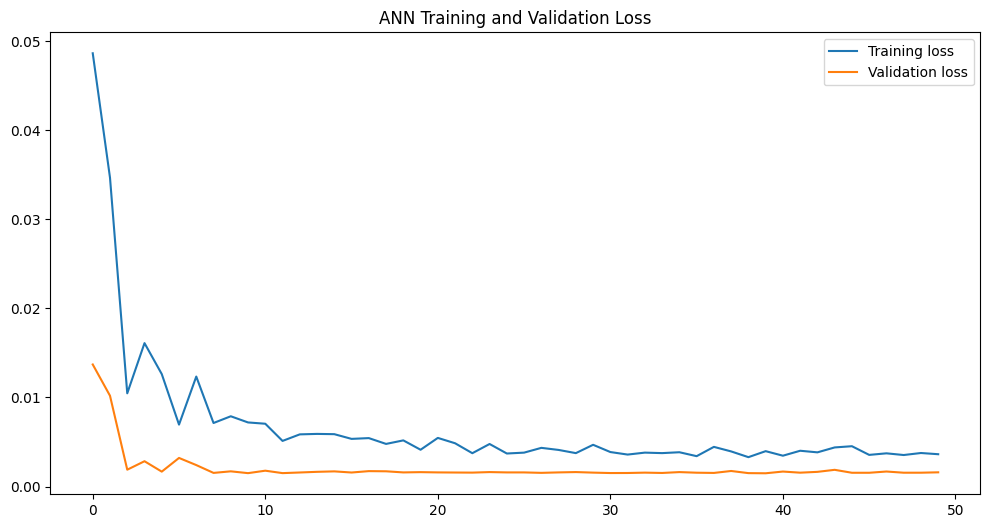

In [107]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [108]:
test_predictions_scaled=model.predict(X_test_scaled)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [109]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 20.6309
RMSE: 4.5421
MAE: 2.3959
MAPE: 34.04%
R²: 0.9367


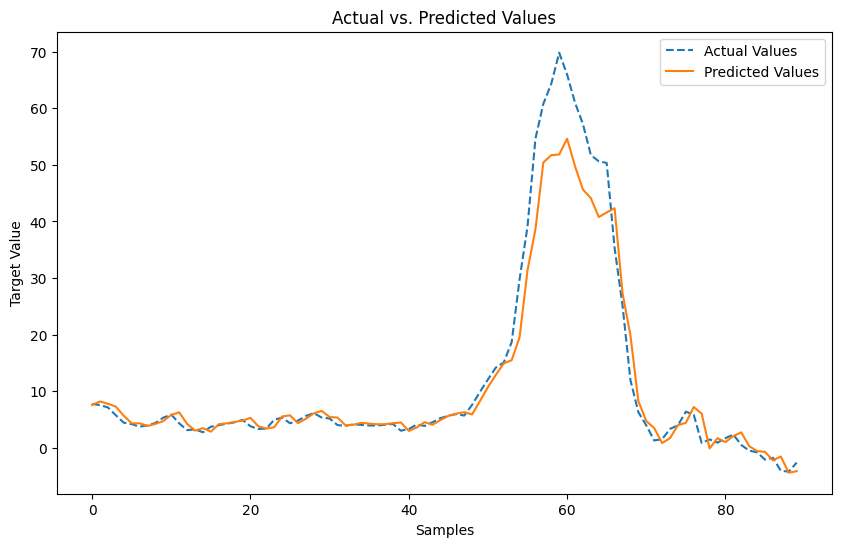

In [110]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 4

In [111]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [112]:

df=data.copy()
df = df.astype(float)


In [113]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [114]:
# Number of lags to create
lags = 4
lagged_features = create_lagged_features(df, lags)


In [115]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [116]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [117]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4'],
      dtype='object')


In [118]:
df2=lagged_features.dropna()

In [119]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-05-31   2.382412         3.672022         4.469678         1.940367   
2000-06-30   6.799835         2.382412         3.672022         4.469678   
2000-07-31  10.139831         6.799835         2.382412         3.672022   
2000-08-31   9.876072        10.139831         6.799835         2.382412   
2000-09-30   8.455851         9.876072        10.139831         6.799835   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

299

In [120]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0


In [121]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [122]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,,
2000-05-31,2.382412,3.672022,4.469678,1.940367,0.329139
2000-06-30,6.799835,2.382412,3.672022,4.469678,1.940367
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239


In [123]:
train_size = int(len(df2) * 0.7)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [124]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,,
2000-05-31,2.382412,3.672022,4.469678,1.940367,0.329139
2000-06-30,6.799835,2.382412,3.672022,4.469678,1.940367
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...
2017-05-31,6.008969,6.940639,7.274401,6.770357,5.545455
2017-06-30,6.095406,6.008969,6.940639,7.274401,6.770357
2017-07-31,4.828797,6.095406,6.008969,6.940639,7.274401


In [125]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [126]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,,
2000-05-31,2.382412,3.672022,4.469678,1.940367,0.329139
2000-06-30,6.799835,2.382412,3.672022,4.469678,1.940367
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...
2017-05-31,6.008969,6.940639,7.274401,6.770357,5.545455
2017-06-30,6.095406,6.008969,6.940639,7.274401,6.770357
2017-07-31,4.828797,6.095406,6.008969,6.940639,7.274401


In [127]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2017-10-31,7.760928
2017-11-30,7.570423
2017-12-31,7.149085
2018-01-31,5.770887
2018-02-28,4.455870
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [128]:
from sklearn.preprocessing import MinMaxScaler

In [129]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4'],
      dtype='object')

In [130]:
ytrain

,Inflation
Date,
2000-05-31,2.382412
2000-06-30,6.799835
2000-07-31,10.139831
2000-08-31,9.876072
2000-09-30,8.455851
...,...
2017-05-31,6.008969
2017-06-30,6.095406
2017-07-31,4.828797


In [131]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [132]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [133]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,
2000-05-31,3.672022,4.469678,1.940367,0.329139
2000-06-30,2.382412,3.672022,4.469678,1.940367
2000-07-31,6.799835,2.382412,3.672022,4.469678
2000-08-31,10.139831,6.799835,2.382412,3.672022
2000-09-30,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...
2017-05-31,6.940639,7.274401,6.770357,5.545455
2017-06-30,6.008969,6.940639,7.274401,6.770357
2017-07-31,6.095406,6.008969,6.940639,7.274401


In [134]:
df1=pd.DataFrame(ytrain)

In [135]:
X_train_scaled

array([[0.1064167 , 0.13546829, 0.04334777, 0.        ],
       [0.05944757, 0.1064167 , 0.13546829, 0.05779654],
       [0.22033542, 0.05944757, 0.1064167 , 0.14852572],
       [0.34198205, 0.22033542, 0.05944757, 0.11991291],
       [0.33237564, 0.34198205, 0.22033542, 0.07365317],
       [0.2806495 , 0.33237564, 0.34198205, 0.23211106],
       [0.25656207, 0.2806495 , 0.33237564, 0.35192041],
       [0.24800572, 0.25656207, 0.2806495 , 0.34245908],
       [0.36736392, 0.24800572, 0.25656207, 0.29151419],
       [0.56162353, 0.36736392, 0.24800572, 0.26779056],
       [0.57792925, 0.56162353, 0.36736392, 0.25936345],
       [0.45394416, 0.57792925, 0.56162353, 0.37691893],
       [0.47798567, 0.45394416, 0.57792925, 0.56824453],
       [0.56477251, 0.47798567, 0.45394416, 0.58430399],
       [0.5071058 , 0.56477251, 0.47798567, 0.4621915 ],
       [0.45959169, 0.5071058 , 0.56477251, 0.4858699 ],
       [0.38867435, 0.45959169, 0.5071058 , 0.57134596],
       [0.51705461, 0.38867435,

In [136]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [137]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,
2000-05-31,0.106417,0.135468,0.043348,0.000000
2000-06-30,0.059448,0.106417,0.135468,0.057797
2000-07-31,0.220335,0.059448,0.106417,0.148526
2000-08-31,0.341982,0.220335,0.059448,0.119913
2000-09-30,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...
2017-05-31,0.225464,0.237620,0.219262,0.187115
2017-06-30,0.191531,0.225464,0.237620,0.231054
2017-07-31,0.194679,0.191531,0.225464,0.249134


In [138]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [139]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,,
2000-05-31,2.382412,0.106417,0.135468,0.043348,0.000000
2000-06-30,6.799835,0.059448,0.106417,0.135468,0.057797
2000-07-31,10.139831,0.220335,0.059448,0.106417,0.148526
2000-08-31,9.876072,0.341982,0.220335,0.059448,0.119913
2000-09-30,8.455851,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...
2017-05-31,6.008969,0.225464,0.237620,0.219262,0.187115
2017-06-30,6.095406,0.191531,0.225464,0.237620,0.231054
2017-07-31,4.828797,0.194679,0.191531,0.225464,0.249134


In [140]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4
Date,,,,
2000-05-31,0.106417,0.135468,0.043348,0.000000
2000-06-30,0.059448,0.106417,0.135468,0.057797
2000-07-31,0.220335,0.059448,0.106417,0.148526
2000-08-31,0.341982,0.220335,0.059448,0.119913
2000-09-30,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...
2017-05-31,0.225464,0.237620,0.219262,0.187115
2017-06-30,0.191531,0.225464,0.237620,0.231054
2017-07-31,0.194679,0.191531,0.225464,0.249134


In [141]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 05:14:42,565] A new study created in memory with name: no-name-b49b599c-1748-46b4-8931-356bea01f203
[I 2025-05-29 05:14:57,776] Trial 0 finished with value: 0.02220797734335065 and parameters: {'input_units': 48, 'activation': 'relu', 'num_layers': 3, 'n_units_0': 80, 'dropout_rate_0': 0.31736394686693675, 'n_units_1': 80, 'dropout_rate_1': 0.29668776808410535, 'n_units_2': 96, 'dropout_rate_2': 0.2237304448960422, 'optimizer': 'SGD', 'batch_size': 48, 'epochs': 40}. Best is trial 0 with value: 0.02220797734335065.
[I 2025-05-29 05:15:08,946] Trial 1 finished with value: 0.005371597106568515 and parameters: {'input_units': 32, 'activation': 'relu', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.11320882118261522, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 30}. Best is trial 1 with value: 0.005371597106568515.
[I 2025-05-29 05:15:35,024] Trial 2 finished with value: 0.06735136359930038 and parameters: {'input_units': 16, 'activation': 'sigmoid', 'num_layers': 

Best hyperparameters:  {'input_units': 96, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 80, 'dropout_rate_0': 0.3092735718368468, 'n_units_1': 64, 'dropout_rate_1': 0.1138218658516481, 'optimizer': 'RMSprop', 'batch_size': 16, 'epochs': 30}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 96, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 80, 'dropout_rate_0': 0.3092735718368468, 'n_units_1': 64, 'dropout_rate_1': 0.1138218658516481, 'optimizer': 'RMSprop', 'batch_size': 16, 'epochs': 30}
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0268 - mae: 0.1186 - val_loss: 0.0040 - val_mae: 0.0516
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0190 - mae: 0.1031 - val_loss: 0.0023 - val_mae: 0.0377
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - mae: 0.0753 - val_loss: 0.0020 - val_mae: 0.0358
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0661 - val_loss: 0.0020 - val_mae: 0.0333
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0080 - mae: 0.0606 - val_loss: 0.0019 - val_mae: 0.0297
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056 - mae: 0.0546 - val_loss: 0.0019 - val_mae: 0.0357
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

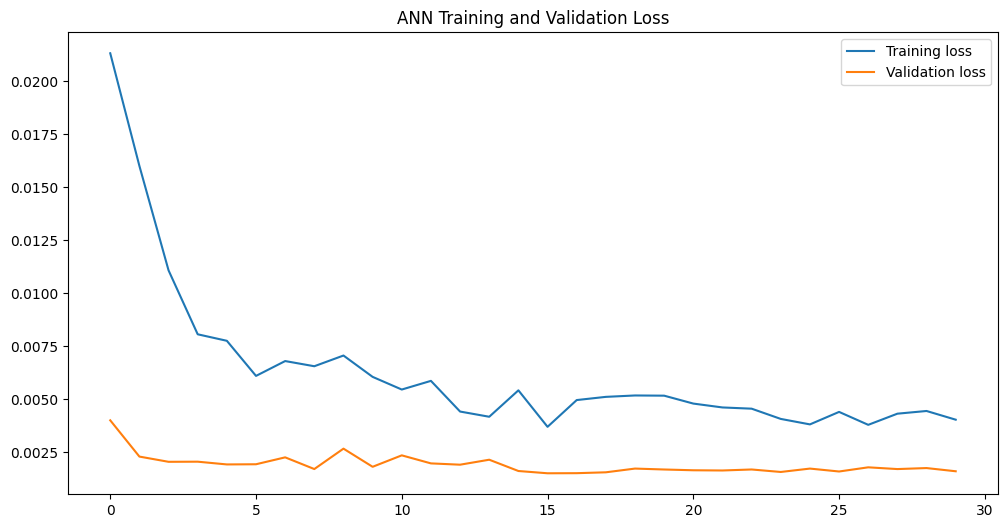

In [142]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [143]:
test_predictions_scaled=model.predict(X_test_scaled)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [144]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 21.2771
RMSE: 4.6127
MAE: 2.4305
MAPE: 33.18%
R²: 0.9347


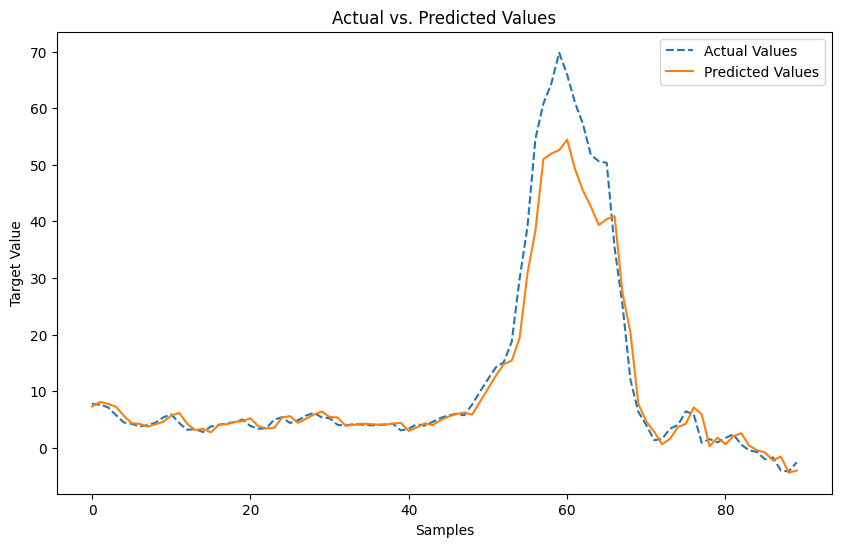

In [145]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 5

In [146]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [147]:

df=data.copy()
df = df.astype(float)


In [148]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [149]:
# Number of lags to create
lags = 5
lagged_features = create_lagged_features(df, lags)


In [150]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [151]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [152]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5'],
      dtype='object')


In [153]:
df2=lagged_features.dropna()

In [154]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-06-30   6.799835         2.382412         3.672022         4.469678   
2000-07-31  10.139831         6.799835         2.382412         3.672022   
2000-08-31   9.876072        10.139831         6.799835         2.382412   
2000-09-30   8.455851         9.876072        10.139831         6.799835   
2000-10-31   7.794494         8.455851         9.876072        10.139831   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

298

In [155]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0
Inflation_lag_5,0


In [156]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [157]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,,
2000-06-30,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239,0.526039


In [158]:
train_size = int(len(df2) * 0.7)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [159]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,,
2000-06-30,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...
2017-05-31,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659
2017-06-30,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455
2017-07-31,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357


In [160]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [161]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,,
2000-06-30,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...
2017-05-31,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659
2017-06-30,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455
2017-07-31,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357


In [162]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2017-10-31,7.760928
2017-11-30,7.570423
2017-12-31,7.149085
2018-01-31,5.770887
2018-02-28,4.455870
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [163]:
from sklearn.preprocessing import MinMaxScaler

In [164]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5'],
      dtype='object')

In [165]:
ytrain

,Inflation
Date,
2000-06-30,6.799835
2000-07-31,10.139831
2000-08-31,9.876072
2000-09-30,8.455851
2000-10-31,7.794494
...,...
2017-05-31,6.008969
2017-06-30,6.095406
2017-07-31,4.828797


In [166]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [167]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [168]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,
2000-06-30,2.382412,3.672022,4.469678,1.940367,0.329139
2000-07-31,6.799835,2.382412,3.672022,4.469678,1.940367
2000-08-31,10.139831,6.799835,2.382412,3.672022,4.469678
2000-09-30,9.876072,10.139831,6.799835,2.382412,3.672022
2000-10-31,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...
2017-05-31,6.940639,7.274401,6.770357,5.545455,4.462659
2017-06-30,6.008969,6.940639,7.274401,6.770357,5.545455
2017-07-31,6.095406,6.008969,6.940639,7.274401,6.770357


In [169]:
df1=pd.DataFrame(ytrain)

In [170]:
X_train_scaled

array([[0.05944757, 0.1064167 , 0.13546829, 0.04334777, 0.        ],
       [0.22033542, 0.05944757, 0.1064167 , 0.13546829, 0.05779654],
       [0.34198205, 0.22033542, 0.05944757, 0.1064167 , 0.14852572],
       ...,
       [0.19467928, 0.19153111, 0.22546367, 0.23761969, 0.23105364],
       [0.14854785, 0.19467928, 0.19153111, 0.22546367, 0.24913428],
       [0.19035972, 0.14854785, 0.19467928, 0.19153111, 0.23716186]])

In [171]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [172]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,
2000-06-30,0.059448,0.106417,0.135468,0.043348,0.000000
2000-07-31,0.220335,0.059448,0.106417,0.135468,0.057797
2000-08-31,0.341982,0.220335,0.059448,0.106417,0.148526
2000-09-30,0.332376,0.341982,0.220335,0.059448,0.119913
2000-10-31,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...
2017-05-31,0.225464,0.237620,0.219262,0.174649,0.148274
2017-06-30,0.191531,0.225464,0.237620,0.219262,0.187115
2017-07-31,0.194679,0.191531,0.225464,0.237620,0.231054


In [173]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [174]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,,
2000-06-30,6.799835,0.059448,0.106417,0.135468,0.043348,0.000000
2000-07-31,10.139831,0.220335,0.059448,0.106417,0.135468,0.057797
2000-08-31,9.876072,0.341982,0.220335,0.059448,0.106417,0.148526
2000-09-30,8.455851,0.332376,0.341982,0.220335,0.059448,0.119913
2000-10-31,7.794494,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...
2017-05-31,6.008969,0.225464,0.237620,0.219262,0.174649,0.148274
2017-06-30,6.095406,0.191531,0.225464,0.237620,0.219262,0.187115
2017-07-31,4.828797,0.194679,0.191531,0.225464,0.237620,0.231054


In [175]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5
Date,,,,,
2000-06-30,0.059448,0.106417,0.135468,0.043348,0.000000
2000-07-31,0.220335,0.059448,0.106417,0.135468,0.057797
2000-08-31,0.341982,0.220335,0.059448,0.106417,0.148526
2000-09-30,0.332376,0.341982,0.220335,0.059448,0.119913
2000-10-31,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...
2017-05-31,0.225464,0.237620,0.219262,0.174649,0.148274
2017-06-30,0.191531,0.225464,0.237620,0.219262,0.187115
2017-07-31,0.194679,0.191531,0.225464,0.237620,0.231054


In [176]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 05:31:39,084] A new study created in memory with name: no-name-9d100a68-5bea-49df-ac26-a6daeb104dde
[I 2025-05-29 05:31:52,841] Trial 0 finished with value: 0.013118058419786393 and parameters: {'input_units': 48, 'activation': 'tanh', 'num_layers': 3, 'n_units_0': 80, 'dropout_rate_0': 0.27711684296762684, 'n_units_1': 32, 'dropout_rate_1': 0.24211840870638418, 'n_units_2': 96, 'dropout_rate_2': 0.014196654668192532, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 40}. Best is trial 0 with value: 0.013118058419786393.
[I 2025-05-29 05:32:17,441] Trial 1 finished with value: 0.028559279069304465 and parameters: {'input_units': 128, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.440478557540518, 'n_units_1': 128, 'dropout_rate_1': 0.17228069492645548, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 70}. Best is trial 0 with value: 0.013118058419786393.
[I 2025-05-29 05:32:30,390] Trial 2 finished with value: 0.004685606341809034 and parameters:

Best hyperparameters:  {'input_units': 112, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 80, 'dropout_rate_0': 0.2605067192387218, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 40}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 112, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 80, 'dropout_rate_0': 0.2605067192387218, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 40}
Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0180 - mae: 0.1066 - val_loss: 0.0025 - val_mae: 0.0419
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0201 - mae: 0.1036 - val_loss: 0.0034 - val_mae: 0.0467
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0116 - mae: 0.0846 - val_loss: 0.0022 - val_mae: 0.0388
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0069 - mae: 0.0651 - val_loss: 0.0024 - val_mae: 0.0390
Epoch 5/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0074 - mae: 0.0627 - val_loss: 0.0026 - val_mae: 0.0388
Epoch 6/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0071 - mae: 0.0632 - val_loss: 0.0022 - val_mae: 0.0359
Epoch 7/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0078 - mae: 0.0621 - val_loss: 0.0023 - val_mae: 0.0360
Epoc

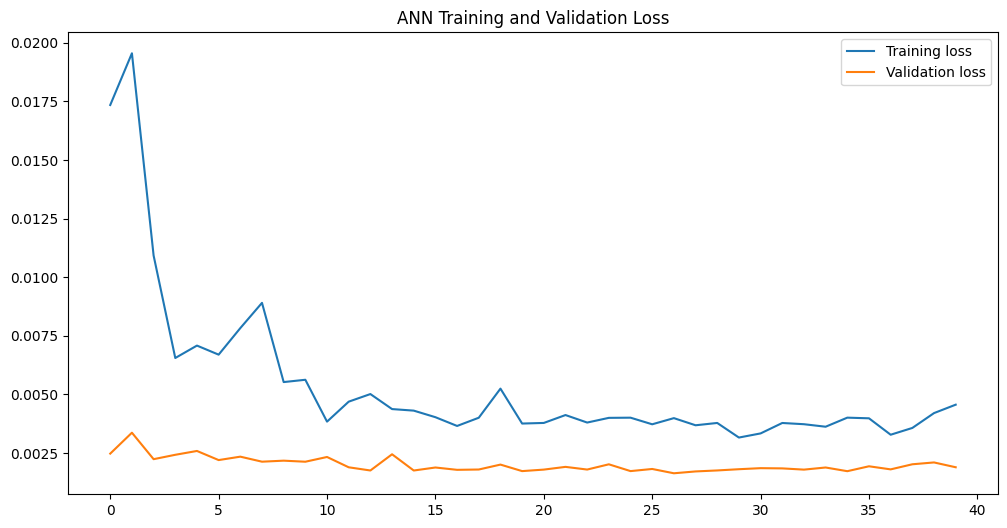

In [177]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [178]:
test_predictions_scaled=model.predict(X_test_scaled)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [179]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 39.5363
RMSE: 6.2878
MAE: 3.2365
MAPE: 40.50%
R²: 0.8787


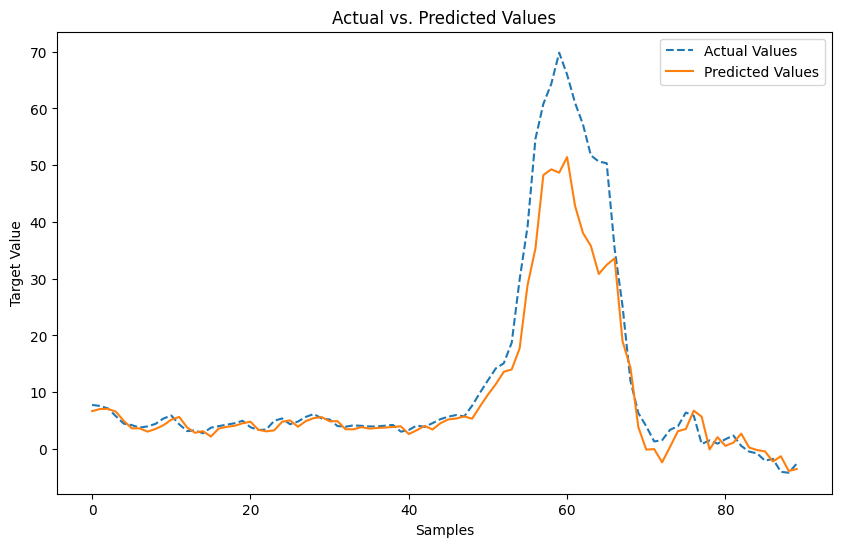

In [180]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 6

In [181]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [182]:

df=data.copy()
df = df.astype(float)


In [183]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [184]:
# Number of lags to create
lags = 6
lagged_features = create_lagged_features(df, lags)


In [185]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [186]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [187]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6'],
      dtype='object')


In [188]:
df2=lagged_features.dropna()

In [189]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-07-31  10.139831         6.799835         2.382412         3.672022   
2000-08-31   9.876072        10.139831         6.799835         2.382412   
2000-09-30   8.455851         9.876072        10.139831         6.799835   
2000-10-31   7.794494         8.455851         9.876072        10.139831   
2000-11-30   7.559566         7.794494         8.455851         9.876072   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

297

In [190]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0
Inflation_lag_5,0
Inflation_lag_6,0


In [191]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [192]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,,
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931


In [193]:
train_size = int(len(df2) * 0.7)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [194]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,,
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...
2017-05-31,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304
2017-06-30,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659
2017-07-31,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455


In [195]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [196]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,,
2000-07-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...
2017-05-31,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304
2017-06-30,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659
2017-07-31,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455


In [197]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2017-10-31,7.760928
2017-11-30,7.570423
2017-12-31,7.149085
2018-01-31,5.770887
2018-02-28,4.455870
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [198]:
from sklearn.preprocessing import MinMaxScaler

In [199]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6'],
      dtype='object')

In [200]:
ytrain

,Inflation
Date,
2000-07-31,10.139831
2000-08-31,9.876072
2000-09-30,8.455851
2000-10-31,7.794494
2000-11-30,7.559566
...,...
2017-05-31,6.008969
2017-06-30,6.095406
2017-07-31,4.828797


In [201]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [202]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [203]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,
2000-07-31,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-08-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-09-30,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-10-31,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-11-30,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...
2017-05-31,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304
2017-06-30,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659
2017-07-31,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455


In [204]:
df1=pd.DataFrame(ytrain)

In [205]:
X_train_scaled

array([[0.22033542, 0.05944757, 0.1064167 , 0.13546829, 0.04334777,
        0.        ],
       [0.34198205, 0.22033542, 0.05944757, 0.1064167 , 0.13546829,
        0.05779654],
       [0.33237564, 0.34198205, 0.22033542, 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [0.19467928, 0.19153111, 0.22546367, 0.23761969, 0.21926178,
        0.18711503],
       [0.14854785, 0.19467928, 0.19153111, 0.22546367, 0.23761969,
        0.23105364],
       [0.19035972, 0.14854785, 0.19467928, 0.19153111, 0.22546367,
        0.24913428]])

In [206]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [207]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,
2000-07-31,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2000-08-31,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2000-09-30,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2000-10-31,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2000-11-30,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...
2017-05-31,0.225464,0.237620,0.219262,0.174649,0.135213,0.132729
2017-06-30,0.191531,0.225464,0.237620,0.219262,0.174649,0.148274
2017-07-31,0.194679,0.191531,0.225464,0.237620,0.219262,0.187115


In [208]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [209]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,,
2000-07-31,10.139831,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2000-08-31,9.876072,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2000-09-30,8.455851,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2000-10-31,7.794494,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2000-11-30,7.559566,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...
2017-05-31,6.008969,0.225464,0.237620,0.219262,0.174649,0.135213,0.132729
2017-06-30,6.095406,0.191531,0.225464,0.237620,0.219262,0.174649,0.148274
2017-07-31,4.828797,0.194679,0.191531,0.225464,0.237620,0.219262,0.187115


In [210]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6
Date,,,,,,
2000-07-31,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2000-08-31,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2000-09-30,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2000-10-31,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2000-11-30,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...
2017-05-31,0.225464,0.237620,0.219262,0.174649,0.135213,0.132729
2017-06-30,0.191531,0.225464,0.237620,0.219262,0.174649,0.148274
2017-07-31,0.194679,0.191531,0.225464,0.237620,0.219262,0.187115


In [211]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 05:50:36,944] A new study created in memory with name: no-name-ca461ec6-b515-406f-b2f5-bb106ff7bea2
[I 2025-05-29 05:50:53,886] Trial 0 finished with value: 0.002802068111486733 and parameters: {'input_units': 112, 'activation': 'tanh', 'num_layers': 3, 'n_units_0': 48, 'dropout_rate_0': 0.05855156453028837, 'n_units_1': 32, 'dropout_rate_1': 0.15750891236239756, 'n_units_2': 16, 'dropout_rate_2': 0.2647894171796566, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 40}. Best is trial 0 with value: 0.002802068111486733.
[I 2025-05-29 05:51:38,198] Trial 1 finished with value: 0.04192221248522401 and parameters: {'input_units': 112, 'activation': 'sigmoid', 'num_layers': 3, 'n_units_0': 48, 'dropout_rate_0': 0.13647972190773483, 'n_units_1': 16, 'dropout_rate_1': 0.013053047791346806, 'n_units_2': 80, 'dropout_rate_2': 0.19972891762149453, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 100}. Best is trial 0 with value: 0.002802068111486733.
[I 2025-05-29 05:51:59,874] Tri

Best hyperparameters:  {'input_units': 96, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.34864479913979946, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 100}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 96, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.34864479913979946, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 100}
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.2737 - mae: 0.4139 - val_loss: 0.0160 - val_mae: 0.1167
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0860 - mae: 0.2389 - val_loss: 0.0262 - val_mae: 0.1534
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0621 - mae: 0.1955 - val_loss: 0.0021 - val_mae: 0.0404
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0301 - mae: 0.1187 - val_loss: 0.0041 - val_mae: 0.0526
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0364 - mae: 0.1326 - val_loss: 0.0027 - val_mae: 0.0443
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0162 - mae: 0.0913 - val_loss: 0.0057 - val_mae: 0.0605
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0160 - mae: 0.0979 - val_loss: 0.0035 - val_mae: 0.

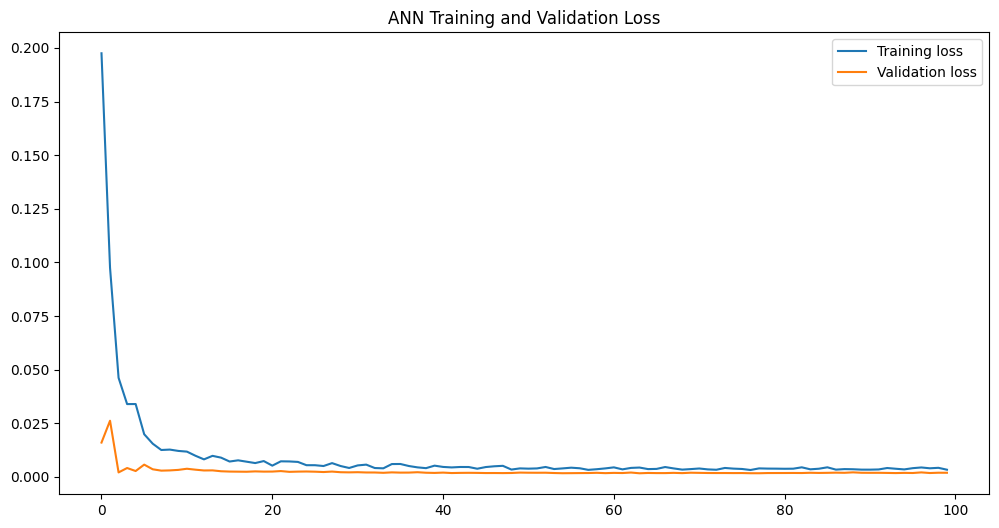

In [212]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [213]:
test_predictions_scaled=model.predict(X_test_scaled)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [214]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 19.0757
RMSE: 4.3676
MAE: 2.3944
MAPE: 40.03%
R²: 0.9415


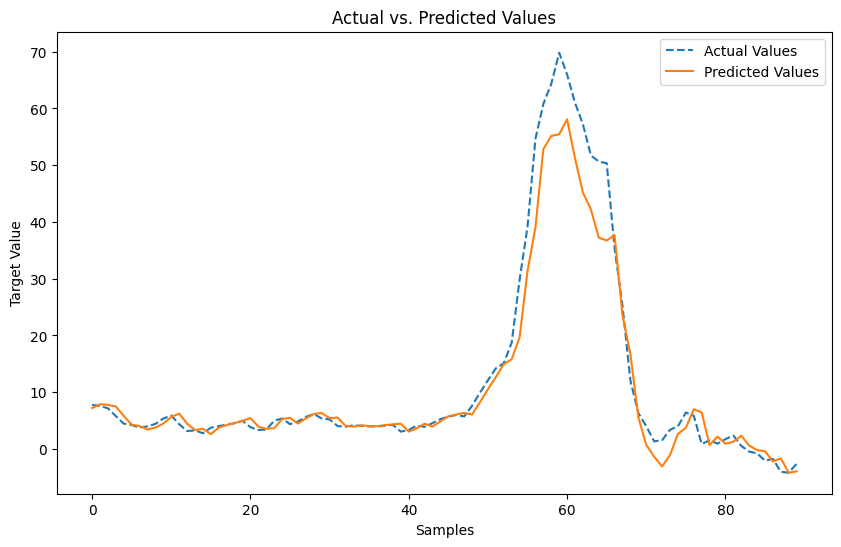

In [215]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 7

In [216]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [217]:

df=data.copy()
df = df.astype(float)


In [218]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [219]:
# Number of lags to create
lags = 7
lagged_features = create_lagged_features(df, lags)


In [220]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [221]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [222]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7'],
      dtype='object')


In [223]:
df2=lagged_features.dropna()

In [224]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-08-31   9.876072        10.139831         6.799835         2.382412   
2000-09-30   8.455851         9.876072        10.139831         6.799835   
2000-10-31   7.794494         8.455851         9.876072        10.139831   
2000-11-30   7.559566         7.794494         8.455851         9.876072   
2000-12-31  10.836729         7.559566         7.794494         8.455851   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

296

In [225]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0
Inflation_lag_5,0
Inflation_lag_6,0
Inflation_lag_7,0


In [226]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [227]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,,
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069


In [228]:
train_size = int(len(df2) * 0.7)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [229]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,,
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...
2017-06-30,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304
2017-07-31,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659
2017-08-31,5.976806,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455


In [230]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [231]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,,
2000-08-31,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...
2017-06-30,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304
2017-07-31,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659
2017-08-31,5.976806,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455


In [232]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2017-11-30,7.570423
2017-12-31,7.149085
2018-01-31,5.770887
2018-02-28,4.455870
2018-03-31,4.206009
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [233]:
from sklearn.preprocessing import MinMaxScaler

In [234]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7'],
      dtype='object')

In [235]:
ytrain

,Inflation
Date,
2000-08-31,9.876072
2000-09-30,8.455851
2000-10-31,7.794494
2000-11-30,7.559566
2000-12-31,10.836729
...,...
2017-06-30,6.095406
2017-07-31,4.828797
2017-08-31,5.976806


In [236]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [237]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [238]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,
2000-08-31,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-09-30,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-10-31,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-11-30,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2000-12-31,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...
2017-06-30,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304
2017-07-31,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659
2017-08-31,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455


In [239]:
df1=pd.DataFrame(ytrain)

In [240]:
X_train_scaled

array([[0.34198205, 0.22033542, 0.05944757, ..., 0.13546829, 0.04334777,
        0.        ],
       [0.33237564, 0.34198205, 0.22033542, ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.2806495 , 0.33237564, 0.34198205, ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [0.14854785, 0.19467928, 0.19153111, ..., 0.23761969, 0.21926178,
        0.18711503],
       [0.19035972, 0.14854785, 0.19467928, ..., 0.22546367, 0.23761969,
        0.23105364],
       [0.23003637, 0.19035972, 0.14854785, ..., 0.19153111, 0.22546367,
        0.24913428]])

In [241]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [242]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,
2000-08-31,0.341982,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2000-09-30,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2000-10-31,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2000-11-30,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2000-12-31,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...
2017-06-30,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.132729
2017-07-31,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.148274
2017-08-31,0.148548,0.194679,0.191531,0.225464,0.237620,0.219262,0.187115


In [243]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [244]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,,
2000-08-31,9.876072,0.341982,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2000-09-30,8.455851,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2000-10-31,7.794494,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2000-11-30,7.559566,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2000-12-31,10.836729,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...
2017-06-30,6.095406,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.132729
2017-07-31,4.828797,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.148274
2017-08-31,5.976806,0.148548,0.194679,0.191531,0.225464,0.237620,0.219262,0.187115


In [245]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7
Date,,,,,,,
2000-08-31,0.341982,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2000-09-30,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2000-10-31,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2000-11-30,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2000-12-31,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...
2017-06-30,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.132729
2017-07-31,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.148274
2017-08-31,0.148548,0.194679,0.191531,0.225464,0.237620,0.219262,0.187115


In [246]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 06:14:18,399] A new study created in memory with name: no-name-b7d0469b-2480-4a1d-ac63-582540a5b079
[I 2025-05-29 06:14:51,918] Trial 0 finished with value: 0.009252461325377225 and parameters: {'input_units': 80, 'activation': 'relu', 'num_layers': 3, 'n_units_0': 32, 'dropout_rate_0': 0.1550951197151469, 'n_units_1': 16, 'dropout_rate_1': 0.21776180171204934, 'n_units_2': 16, 'dropout_rate_2': 0.4755652088203633, 'optimizer': 'RMSprop', 'batch_size': 48, 'epochs': 100}. Best is trial 0 with value: 0.009252461325377225.
[I 2025-05-29 06:15:23,046] Trial 1 finished with value: 0.007969784364104272 and parameters: {'input_units': 96, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.31466150761949113, 'optimizer': 'SGD', 'batch_size': 48, 'epochs': 100}. Best is trial 1 with value: 0.007969784364104272.
[I 2025-05-29 06:15:51,729] Trial 2 finished with value: 0.0044683035463094715 and parameters: {'input_units': 112, 'activation': 'relu', 'num_lay

Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.18582162209430444, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 60}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.18582162209430444, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 60}
Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0162 - mae: 0.0919 - val_loss: 0.0025 - val_mae: 0.0454
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - mae: 0.0563 - val_loss: 0.0020 - val_mae: 0.0386
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0646 - val_loss: 0.0013 - val_mae: 0.0302
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0063 - mae: 0.0619 - val_loss: 0.0012 - val_mae: 0.0294
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049 - mae: 0.0515 - val_loss: 0.0014 - val_mae: 0.0300
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0501 - val_loss: 0.0011 - val_mae: 0.0283
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mae: 0.0532 - val_loss: 0.0012 - val_mae: 

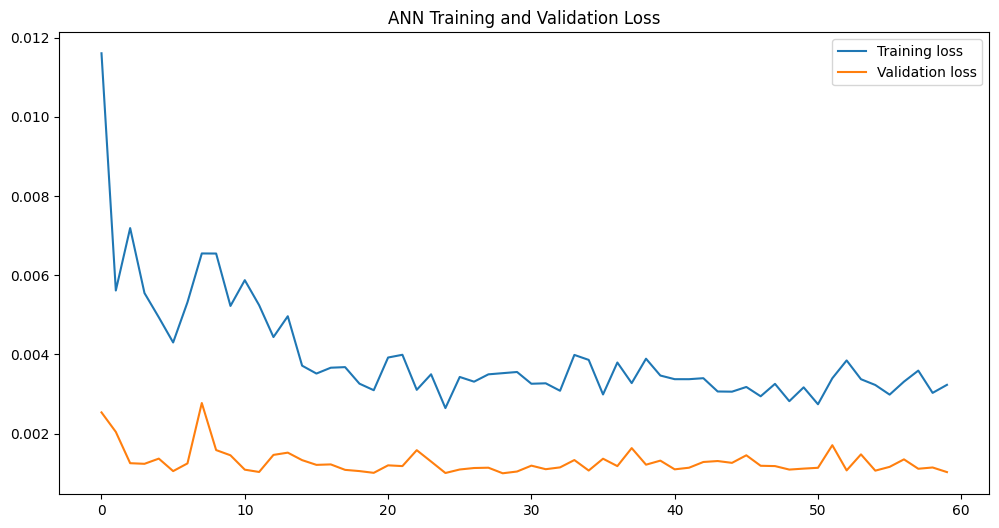

In [247]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [248]:
test_predictions_scaled=model.predict(X_test_scaled)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [249]:
len(test_predictions)

90

In [250]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 22.0749
RMSE: 4.6984
MAE: 2.4532
MAPE: 34.53%
R²: 0.9330


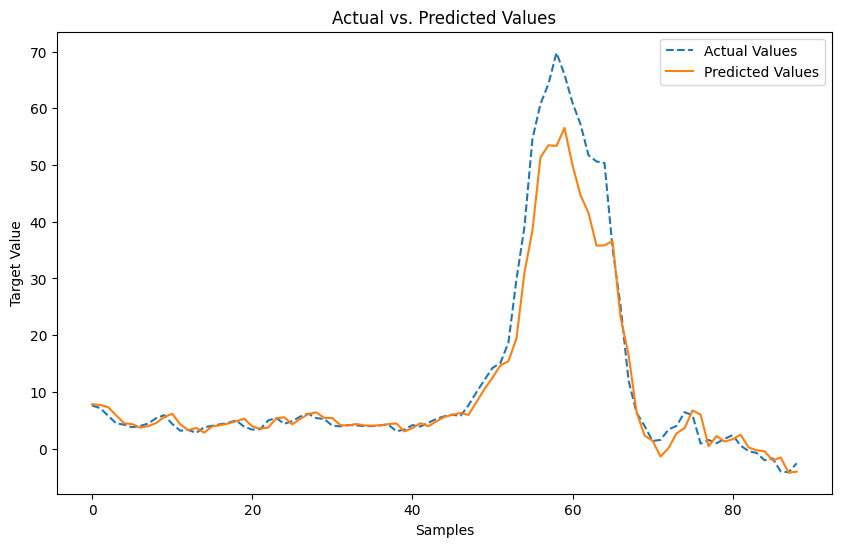

In [251]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 8

In [252]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [253]:

df=data.copy()
df = df.astype(float)


In [254]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [255]:
# Number of lags to create
lags = 8
lagged_features = create_lagged_features(df, lags)


In [256]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [257]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [258]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8'],
      dtype='object')


In [259]:
df2=lagged_features.dropna()

In [260]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-09-30   8.455851         9.876072        10.139831         6.799835   
2000-10-31   7.794494         8.455851         9.876072        10.139831   
2000-11-30   7.559566         7.794494         8.455851         9.876072   
2000-12-31  10.836729         7.559566         7.794494         8.455851   
2001-01-31  16.170425        10.836729         7.559566         7.794494   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

295

In [261]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0
Inflation_lag_5,0
Inflation_lag_6,0
Inflation_lag_7,0
Inflation_lag_8,0


In [262]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [263]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,,
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037


In [264]:
train_size = int(len(df2) * 0.7)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [265]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,,
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...
2017-06-30,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304,4.085422
2017-07-31,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304
2017-08-31,5.976806,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659


In [266]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [267]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,,
2000-09-30,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...
2017-06-30,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304,4.085422
2017-07-31,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304
2017-08-31,5.976806,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659


In [268]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2017-11-30,7.570423
2017-12-31,7.149085
2018-01-31,5.770887
2018-02-28,4.455870
2018-03-31,4.206009
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [269]:
from sklearn.preprocessing import MinMaxScaler

In [270]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8'],
      dtype='object')

In [271]:
ytrain

,Inflation
Date,
2000-09-30,8.455851
2000-10-31,7.794494
2000-11-30,7.559566
2000-12-31,10.836729
2001-01-31,16.170425
...,...
2017-06-30,6.095406
2017-07-31,4.828797
2017-08-31,5.976806


In [272]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [273]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [274]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,
2000-09-30,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-10-31,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-11-30,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2000-12-31,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-01-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...
2017-06-30,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304,4.085422
2017-07-31,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304
2017-08-31,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659


In [275]:
df1=pd.DataFrame(ytrain)

In [276]:
X_train_scaled

array([[0.33237564, 0.34198205, 0.22033542, ..., 0.13546829, 0.04334777,
        0.        ],
       [0.2806495 , 0.33237564, 0.34198205, ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.25656207, 0.2806495 , 0.33237564, ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [0.14854785, 0.19467928, 0.19153111, ..., 0.21926178, 0.17464937,
        0.14827396],
       [0.19035972, 0.14854785, 0.19467928, ..., 0.23761969, 0.21926178,
        0.18711503],
       [0.23003637, 0.19035972, 0.14854785, ..., 0.22546367, 0.23761969,
        0.23105364]])

In [277]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [278]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,
2000-09-30,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2000-10-31,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2000-11-30,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2000-12-31,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2001-01-31,0.367364,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...
2017-06-30,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.119429,0.134742
2017-07-31,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.132729
2017-08-31,0.148548,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.148274


In [279]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [280]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,,
2000-09-30,8.455851,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2000-10-31,7.794494,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2000-11-30,7.559566,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2000-12-31,10.836729,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2001-01-31,16.170425,0.367364,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...
2017-06-30,6.095406,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.119429,0.134742
2017-07-31,4.828797,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.132729
2017-08-31,5.976806,0.148548,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.148274


In [281]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8
Date,,,,,,,,
2000-09-30,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2000-10-31,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2000-11-30,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2000-12-31,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2001-01-31,0.367364,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...
2017-06-30,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.119429,0.134742
2017-07-31,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.132729
2017-08-31,0.148548,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.148274


In [282]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 06:35:43,434] A new study created in memory with name: no-name-e6ba5a18-b83a-4cb7-ae0e-cf82bc5ef931
[I 2025-05-29 06:36:08,081] Trial 0 finished with value: 0.04464498688466847 and parameters: {'input_units': 80, 'activation': 'sigmoid', 'num_layers': 2, 'n_units_0': 48, 'dropout_rate_0': 0.3527896676358937, 'n_units_1': 48, 'dropout_rate_1': 0.07856488685898899, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 70}. Best is trial 0 with value: 0.04464498688466847.
[I 2025-05-29 06:36:27,684] Trial 1 finished with value: 0.006490741483867168 and parameters: {'input_units': 32, 'activation': 'relu', 'num_layers': 3, 'n_units_0': 96, 'dropout_rate_0': 0.3957839279379438, 'n_units_1': 128, 'dropout_rate_1': 0.16736550567376107, 'n_units_2': 16, 'dropout_rate_2': 0.051223777756690014, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 50}. Best is trial 1 with value: 0.006490741483867168.
[I 2025-05-29 06:36:36,800] Trial 2 finished with value: 0.0051359896082431074 and param

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 128, 'dropout_rate_0': 0.3772974131966139, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 90}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 128, 'dropout_rate_0': 0.3772974131966139, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 90}
Epoch 1/90
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0490 - mae: 0.1556 - val_loss: 0.0051 - val_mae: 0.0681
Epoch 2/90
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0313 - mae: 0.1338 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 3/90
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0184 - mae: 0.0973 - val_loss: 0.0018 - val_mae: 0.0362
Epoch 4/90
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0133 - mae: 0.0870 - val_loss: 0.0014 - val_mae: 0.0292
Epoch 5/90
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0111 - mae: 0.0803 - val_loss: 0.0011 - val_mae: 0.0282
Epoch 6/90
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0098 - mae: 0.0720 - val_loss: 9.9385e-04 - val_mae: 0.0265
Epoch 7/90
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0106 - mae: 0.0731 - val_loss: 0.0010 - val_mae: 0.0267

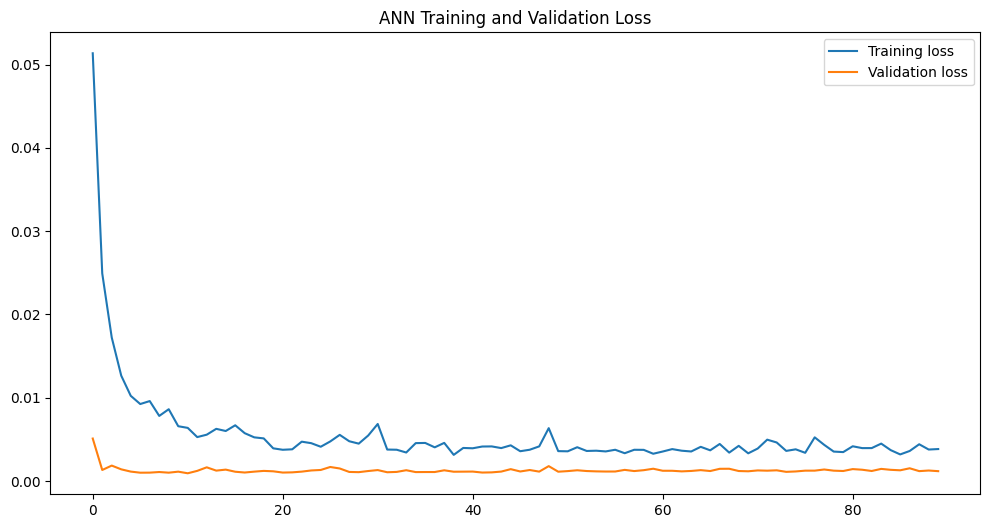

In [283]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [284]:
test_predictions_scaled=model.predict(X_test_scaled)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [285]:
len(test_predictions)

89

In [286]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 16.4507
RMSE: 4.0559
MAE: 2.2722
MAPE: 40.25%
R²: 0.9501


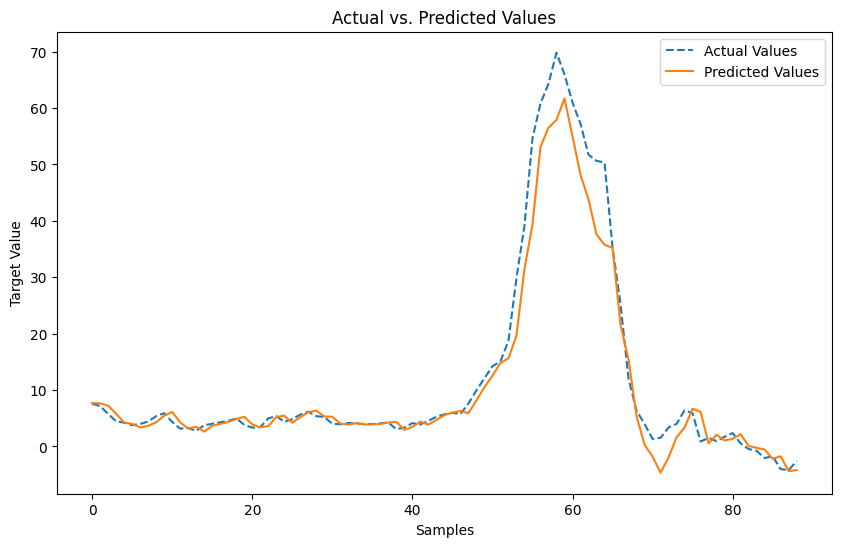

In [287]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 9

In [288]:

df=data.copy()
df = df.astype(float)


In [289]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [290]:
# Number of lags to create
lags = 9
lagged_features = create_lagged_features(df, lags)


In [291]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [292]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [293]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9'],
      dtype='object')


In [294]:
df2=lagged_features.dropna()

In [295]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-10-31   7.794494         8.455851         9.876072        10.139831   
2000-11-30   7.559566         7.794494         8.455851         9.876072   
2000-12-31  10.836729         7.559566         7.794494         8.455851   
2001-01-31  16.170425        10.836729         7.559566         7.794494   
2001-02-28  16.618124        16.170425        10.836729         7.559566   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

294

In [296]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0
Inflation_lag_5,0
Inflation_lag_6,0
Inflation_lag_7,0
Inflation_lag_8,0
Inflation_lag_9,0


In [297]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [298]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,,
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795,5.857520
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060


In [299]:
train_size = int(len(df2) * 0.7)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [300]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,,
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...
2017-06-30,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304,4.085422,4.193849
2017-07-31,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304,4.085422
2017-08-31,5.976806,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304


In [301]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [302]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,,
2000-10-31,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...
2017-06-30,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304,4.085422,4.193849
2017-07-31,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304,4.085422
2017-08-31,5.976806,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304


In [303]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

,Inflation
Date,
2017-11-30,7.570423
2017-12-31,7.149085
2018-01-31,5.770887
2018-02-28,4.455870
2018-03-31,4.206009
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [304]:
from sklearn.preprocessing import MinMaxScaler

In [305]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9'],
      dtype='object')

In [306]:
ytrain

,Inflation
Date,
2000-10-31,7.794494
2000-11-30,7.559566
2000-12-31,10.836729
2001-01-31,16.170425
2001-02-28,16.618124
...,...
2017-06-30,6.095406
2017-07-31,4.828797
2017-08-31,5.976806


In [307]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [308]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [309]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,
2000-10-31,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-11-30,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2000-12-31,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-01-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-02-28,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...
2017-06-30,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304,4.085422,4.193849
2017-07-31,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304,4.085422
2017-08-31,4.828797,6.095406,6.008969,6.940639,7.274401,6.770357,5.545455,4.462659,4.029304


In [310]:
df1=pd.DataFrame(ytrain)

In [311]:
X_train_scaled

array([[0.2806495 , 0.33237564, 0.34198205, ..., 0.13546829, 0.04334777,
        0.        ],
       [0.25656207, 0.2806495 , 0.33237564, ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.24800572, 0.25656207, 0.2806495 , ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [0.14854785, 0.19467928, 0.19153111, ..., 0.17464937, 0.13521267,
        0.13272903],
       [0.19035972, 0.14854785, 0.19467928, ..., 0.21926178, 0.17464937,
        0.14827396],
       [0.23003637, 0.19035972, 0.14854785, ..., 0.23761969, 0.21926178,
        0.18711503]])

In [312]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [313]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,
2000-10-31,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2000-11-30,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2000-12-31,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2001-01-31,0.367364,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2001-02-28,0.561624,0.367364,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...
2017-06-30,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.119429,0.121473,0.138631
2017-07-31,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.119429,0.134742
2017-08-31,0.148548,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.132729


In [314]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [315]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,,
2000-10-31,7.794494,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2000-11-30,7.559566,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2000-12-31,10.836729,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2001-01-31,16.170425,0.367364,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2001-02-28,16.618124,0.561624,0.367364,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...,...
2017-06-30,6.095406,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.119429,0.121473,0.138631
2017-07-31,4.828797,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.119429,0.134742
2017-08-31,5.976806,0.148548,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.132729


In [316]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9
Date,,,,,,,,,
2000-10-31,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2000-11-30,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2000-12-31,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2001-01-31,0.367364,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2001-02-28,0.561624,0.367364,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...
2017-06-30,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.119429,0.121473,0.138631
2017-07-31,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.119429,0.134742
2017-08-31,0.148548,0.194679,0.191531,0.225464,0.237620,0.219262,0.174649,0.135213,0.132729


In [317]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 06:59:26,585] A new study created in memory with name: no-name-437fca95-3758-4559-8a92-9061875e7465
[I 2025-05-29 06:59:38,760] Trial 0 finished with value: 0.00635602306574583 and parameters: {'input_units': 96, 'activation': 'relu', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.4416561024968989, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 30}. Best is trial 0 with value: 0.00635602306574583.
[I 2025-05-29 06:59:48,278] Trial 1 finished with value: 0.014719853829592466 and parameters: {'input_units': 32, 'activation': 'relu', 'num_layers': 3, 'n_units_0': 16, 'dropout_rate_0': 0.27035912333531387, 'n_units_1': 16, 'dropout_rate_1': 0.0659428149324589, 'n_units_2': 64, 'dropout_rate_2': 0.036701478587462644, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 20}. Best is trial 0 with value: 0.00635602306574583.
[I 2025-05-29 06:59:52,502] Trial 2 finished with value: 0.01692126551643014 and parameters: {'input_units': 128, 'activation': 'relu', 'num_layers': 1,

Best hyperparameters:  {'input_units': 64, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.12402823368949267, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 100}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 64, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.12402823368949267, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 100}
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 0.0728 - mae: 0.2067 - val_loss: 0.0069 - val_mae: 0.0725
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0467 - mae: 0.1708 - val_loss: 0.0060 - val_mae: 0.0668
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0396 - mae: 0.1390 - val_loss: 0.0035 - val_mae: 0.0457
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0224 - mae: 0.1095 - val_loss: 0.0047 - val_mae: 0.0509
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0255 - mae: 0.1129 - val_loss: 0.0033 - val_mae: 0.0511
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0144 - mae: 0.0857 - val_loss: 0.0067 - val_mae: 0.0707
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0164 - mae: 0.0995 - val_loss: 0.0049 - val_mae: 0

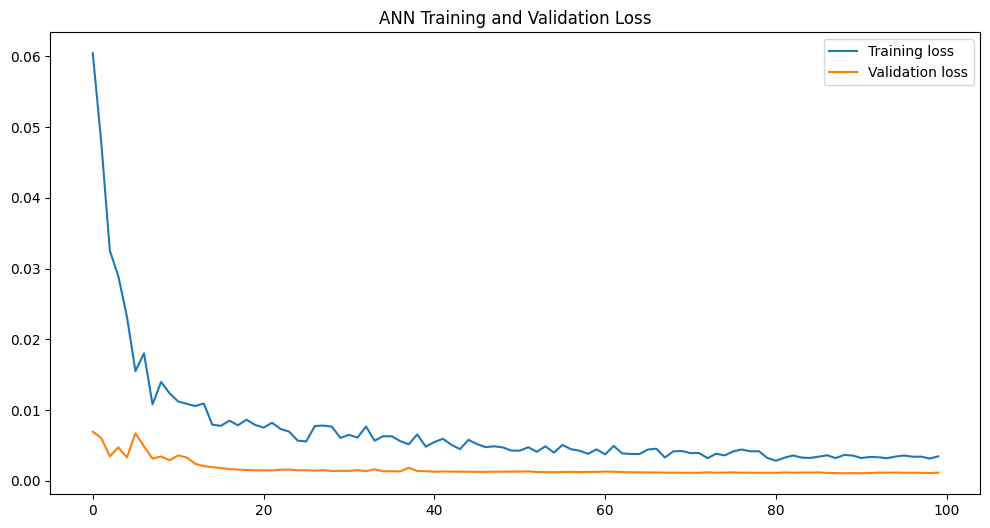

In [318]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [319]:
test_predictions_scaled=model.predict(X_test_scaled)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [320]:
len(test_predictions)

89

In [321]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 30.0634
RMSE: 5.4830
MAE: 2.7754
MAPE: 32.83%
R²: 0.9088


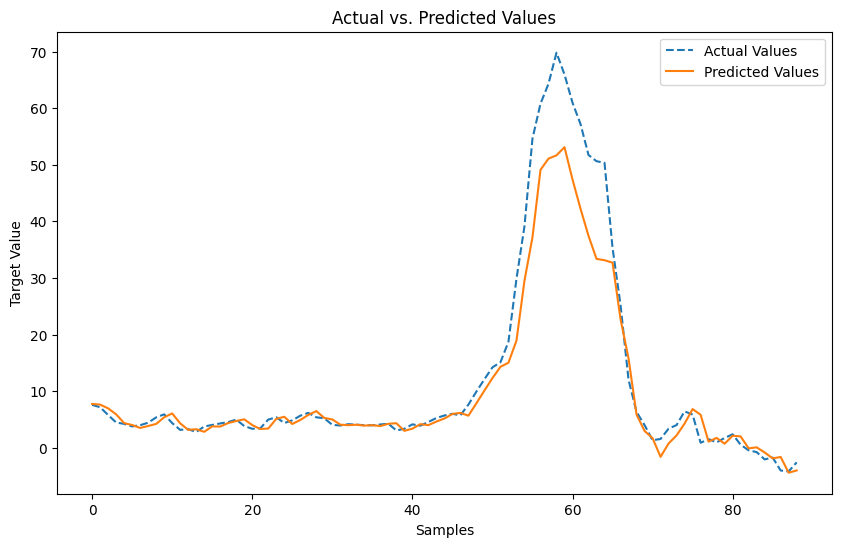

In [322]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()